### LoRA Fine-Tuning with MLX LM

In this notebook, we'll walk through how to [LoRA fine-tune](https://arxiv.org/abs/2106.09685) an LLM with MLX LM. We'll use the [HellaSwag](https://rowanzellers.com/hellaswag/) dataset for common sense reasoning as an example. An outline:

1. Download the dataset and prepare it in the right format for MLX LM.
2. Setup and run LoRA training. We'll show how to capture the training logs and plot some statistics to visualize the performance.
3. Evaluate on the test set. We'll compute the final question-answer accuracy of the fine-tuned model.
4. Fuse the resulting adapters into the base model and upload to Hugging Face.
5. Discuss tips for debugging accuracy and efficiency.

### Install dependencies

In [88]:
# pip install mlx-lm
# pip install matplotlib
# pip install rouge-score
# pip install scikit-learn
# pip install tqdm
# pip install numpy
# pip install json
# pip install pathlib
# pip install transformers
# pip install sentencepiece
# pip install datasets
# pip install torch
# pip install mlflow

### MLFOW CONFIG

In [89]:
import mlflow
mlflow.end_run()

In [90]:
#exp_name="finetuning_comparativa"
exp_name="MLX1.0"
corrida_name="MLX-20_16_1e4"
# base_model = "Llama-3.2-1B-Instruct"
# four_bits = True 
# dataset_path = "FAQ_All.jsonl"
# dataset_type = "alpaca_chat.load_qa"
# output_dir = "../trained_models/adapters/adapters.safetensors"
output_path = "../trained_models/adapters_20_16_1e4/"
output_dir = output_path + 'adapters.safetensors'
sequence_len = 2048
lora_layers = 8
lora_layers_scale = 20.0
grad_checkpoint_value = True



lora_r = 8
# lora_alpha = 16
lora_dropout = 0.0
# gradient_accumulation_steps = 4
optimizer = "adam"
# weight_decay_value = 0.02
lr_scheduler = "linear"
learning_rate_value = 1e-4
batch_size = 16

epochs = 20
steps = 1280

In [91]:
# mlflow.set_tracking_uri("https://4z0r6nts-5000.usw3.devtunnels.ms/") 
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment(experiment_name=exp_name)

<Experiment: artifact_location='mlflow-artifacts:/880645134898555871', creation_time=1733877767863, experiment_id='880645134898555871', last_update_time=1733877767863, lifecycle_stage='active', name='MLX1.0', tags={}>

### Preprocess Data
We'll start by downloading an already pre-processed version of the HellaSwag dataset from [LLM-Adapters](https://github.com/AGI-Edgerunners/LLM-Adapters).

In [92]:
import json
import csv
import numpy as np
from pathlib import Path

# jsonl file path
""" save_path = "./dataset/FAQ_All.jsonl"
with open(save_path, 'r') as file:
	dataset = [json.loads(line) for line in file]
"""

# csv file path
save_path = "./datasets/Parph_Data/FAQs_1000.csv"
dataset = []
with open(save_path, 'r', encoding='utf-8') as file:
	reader = csv.DictReader(file)
	for row in reader:
		dataset.append(row)

print(f"Hello stats: {len(dataset)} lenght trainging dataset")
print("An example:\n")
print(json.dumps(dataset[0], indent=2))

Hello stats: 1024 lenght trainging dataset
An example:

{
  "pregunta": "\u00bfPuedo presentar una p\u00f3liza de bonos en formato electr\u00f3nico?",
  "respuesta": "Este tipo de garant\u00eda es v\u00e1lida, \u00bfno?"
}


Next, let's split the training set into a training and a validation set. We'll pull out a randomly chosen 10% for validation.

In [93]:
# Seed for reproducibility
np.random.seed(43)
perm = np.random.permutation(len(dataset))
valid_size = int(0.2 * len(dataset))
valid_set = [dataset[i] for i in perm[:valid_size]]
train_set = [dataset[i] for i in perm[valid_size:]]

Finally, put the data splits in the MLX LM training format. The format simply expects the data to be in a container which supports random access to the individual examples (e.g. a Python `list`):
```
["An example for the model.", "Another example for the model.", ...]
```
For more details, see the [documentation on supported formats](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#Data).

In [94]:
def clean_text(text):
    text = text.strip()
    text = ' '.join(text.split())
    return text

"""def preprocess(dataset):
    return [
        f"Question: {clean_text(t['question'])}\n"
        f"Answer: {clean_text(t['answer'])}\n"
        for t in dataset
    ]"""
def preprocess(dataset):
    return [
        f"pregunta: {clean_text(t['pregunta'])}\n"
        f"respuesta: {clean_text(t['respuesta'])}\n"
        for t in dataset
    ]

train_set, valid_set = map(preprocess, (train_set, valid_set))

### Fine-Tune

For fine-tuning, we'll use Microsoft's [Phi-3 mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct). At 3.8 billion parameters, Phi-3 mini is a high-quality model that is also fast to fine-tune on most Apple silicon machines. Also, it has a [permissive MIT License](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct/blob/main/LICENSE).

First, import all the packages and functions we need.

In [95]:
import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm.utils import load, generate
from mlx_lm.tuner.trainer import train, evaluate, TrainingArgs
from mlx_lm.tuner.utils import linear_to_lora_layers


Next, setup the LoRA parameters and make the training arguments. See the [training argument class](https://github.com/ml-explore/mlx-examples/blob/81318ad4a8b2ca5fd1431a42db2b0244d16be851/llms/mlx_lm/tuner/trainer.py#L31-L63) for a more detailed list of training parameters. 

Recall the LoRA update is $W^\top \mathbf{x} + c \cdot \mathbf{a} \mathbf{b}^\top \mathbf{x}$ where $\mathbf{a}$ has shape `(D, rank)`.

With that in mind, the LoRA parameters to attend to are:
- `lora_layers`: The number of Transformer blocks from the top of the model to adapt.
- `rank`: The rank of the low-rank adapters. A larger rank implies more adapter parameters per linear layer.
- `scale`: This is the constant $c$ that scales the low-rank update.

In [96]:
# Make a directory to save the adapter config and weights
adapter_path = Path("../trained_models/adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

lora_config = {
 "lora_layers": lora_layers,
 "lora_parameters": {
    "rank": lora_r,
    "scale": lora_layers_scale,
    "dropout": lora_dropout,
    "epochs": epochs
}}

# Save the LoRA config to the adapter path
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)    

training_args = TrainingArgs(
    adapter_file=output_dir,
    iters=steps,
    steps_per_eval=50,
    batch_size=batch_size,
    max_seq_length=sequence_len,
    grad_checkpoint=grad_checkpoint_value,
)

Next, load the Phi-3 mini model. Note this may take a few minutes to download from HuggingFace if you haven't downloaded it before.

In [97]:
model_path = "../original_models/Llama-3.2-1B-Instruct-bf16"
model, tokenizer = load(model_path)

After loading the model, freeze it's parameters so we don't train them. Then convert linear layers to LoRA layers using the MLX LM utility `linear_to_lora_layers`. The adapters in the `LoRA` layers are not frozen, so they will be included in the model's `trainable_parameters`. Check-out the [LoRA layer implementation](https://github.com/ml-explore/mlx-examples/blob/81318ad4a8b2ca5fd1431a42db2b0244d16be851/llms/mlx_lm/tuner/lora.py#L72-L104) to see how it all works.

By default, MLX LM only adapts the query, key, and value projection matrices for Phi-3. You can specify the layers to adapt by setting `lora_parameters["keys"]` to a list of layer names. In this case it defaults to `["attn.qkv_proj"]`. 

In [98]:
# Freeze the base model
model.freeze()

# Convert linear layers to lora layers
linear_to_lora_layers(model, lora_config["lora_layers"], lora_config["lora_parameters"])

num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 425984


### Evaluate Functions

The training and validation loss are only part of the story. For HellaSwag, we ultimately care about how good the model is at answering questions. To asses this, let's generate the actual `ending1`, `ending2`, `ending3`, or `ending4` responses with the fine-tuned model and measure the accuracy.

First, let's split the last word off of each example in the test set to create a prompt without the answer.

In [99]:
import mlx.core as mx
import mlx.nn as nn
import numpy as np
from tqdm import tqdm
from rouge_score import rouge_scorer
from sklearn.metrics import f1_score
from difflib import SequenceMatcher
import os

def similar(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio() > 0.8

def evaluate_model(model, tokenizer, dataset):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    # Adjust generation parameters
    generation_params = {
        "max_tokens": 500,
        "top_p": 0.9,
    }
    
    for example in tqdm(dataset):
        # Get prompt and true answer
        prompt = example["prompt"]
        true_answer = example["response"]
        
        # Generate prediction
        response = generate(model, tokenizer, prompt, **generation_params)
        
        # Store prediction and true label
        all_preds.append(response)
        all_labels.append(true_answer)
        
        # Calculate ROUGE scores
        scores = scorer.score(true_answer, response)
        for key, score in scores.items():
            rouge_scores[key].append(score.fmeasure)

        # Calculate loss/perplexity
        tokens = tokenizer.encode(prompt + true_answer)
        tokens = mx.array(tokens)
        
        # Forward pass
        logits = model(tokens[None])[0]
        
        # Calculate cross entropy loss
        targets = tokens[1:]
        logits = logits[:-1]
        loss = mx.mean(nn.losses.cross_entropy(logits, targets))
        total_loss += float(loss)

    # Calculate metrics
    accuracy = sum(1 for x,y in zip(all_preds, all_labels) if similar(x.strip(), y.strip())) / len(all_preds)
    
    # Convert predictions and labels to match format for F1
    pred_labels = [1 if similar(p.strip(), l.strip()) else 0 for p,l in zip(all_preds, all_labels)]
    true_labels = [1] * len(all_labels)
    f1 = f1_score(true_labels, pred_labels, average='binary')
    
    # Calculate average ROUGE scores
    avg_rouge_scores = {key: np.mean(scores) for key, scores in rouge_scores.items()}

    # Calculate perplexity
    avg_loss = total_loss / len(dataset)
    perplexity = float(mx.exp(mx.array(avg_loss)))

    return accuracy, f1, perplexity, avg_rouge_scores

# Load test dataset
test_set_path = "./datasets/Parph_Data/FAQs_200_testing.jsonl" 
with open(test_set_path, 'r') as file:
    test_set = [json.loads(line) for line in file]

# Define number of test samples
num_test = len(test_set)


Now we're ready to put it all together and actually train the model. We'll use `Adam` for the optimizer, but you can specify any [optimizer](https://ml-explore.github.io/mlx/build/html/python/optimizers/common_optimizers.html) with any [scheduler](https://ml-explore.github.io/mlx/build/html/python/optimizers/schedulers.html). We also added a custom class to capture the training and validation loss to plot it later.

In [100]:
# Checl if the output folder exists, if not, create it:
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"Output folder {output_path} created")
else:
    print(f"Output folder {output_path} already exists")


# Put the model in training mode:
model.train()

# Make the optimizer:
if optimizer == "adam":
    opt = optim.Adam(learning_rate=learning_rate_value)
else:
    opt = optim.AdamW(learning_rate=learning_rate_value, weight_decay=weight_decay_value)

# Make a class to record the training stats:
class Metrics:
    train_losses = []
    val_losses = []
    val_accuracies = []

    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
        try:
            mlflow.log_metric("train_loss", info["train_loss"], step=info["iteration"])
        except Exception as e:
            print(f"Warning: Could not log train metric to MLflow: {e}")
            
    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))
        self.val_accuracies.append((info["iteration"], info["val_loss"]))
        # log validation loss
        try:
            mlflow.log_metric("val_loss", info["val_loss"], step=info["iteration"])
        except Exception as e:
            print(f"Warning: Could not log validation metric to MLflow: {e}")

metrics = Metrics()

with mlflow.start_run(run_name=corrida_name):
    mlflow.log_params({
        "num_train_epoch": lora_config["lora_parameters"]["epochs"],
        "max_steps": training_args.iters,
        "lora_r": lora_config["lora_parameters"]["rank"],
        "lora_dropout":lora_config["lora_parameters"]["dropout"],
        "lora_layers":lora_config["lora_layers"],
        "lora_layeres_scale":lora_config["lora_parameters"]["scale"],
        "batch_size":training_args.batch_size,
        "optimizer":optimizer,
        "learning_rate":learning_rate_value,
        # "weight_decay": weight_decay_value,
        "scheduler":lr_scheduler
    })

    # Train model:
    train(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        optimizer=opt,
        train_dataset=train_set,
        val_dataset=valid_set,
        training_callback=metrics,
    )

    print("\n Starting Evaluation")
    # Evaluate model and log metrics in the same run
    print("Evaluating model...")
    accuracy, f1, perplexity, rouge_scores = evaluate_model(model, tokenizer, test_set[:num_test])

    # Log final metrics
    mlflow.log_metrics({
        "final_train_loss": metrics.train_losses[-1][1],
        "final_val_loss": metrics.val_losses[-1][1],
        "accuracy": accuracy,
        "f1_score": f1,
        "perplexity": perplexity,
        "rouge1": rouge_scores['rouge1'],
        "rouge2": rouge_scores['rouge2'],
        "rougeL": rouge_scores['rougeL']
    })

    # Print results
    print(f"\nResults on {num_test} test samples:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1:.3f}") 
    print(f"Perplexity: {perplexity:.3f}")
    print("\nROUGE Scores:")
    for key, score in rouge_scores.items():
        print(f"{key}: {score:.3f}")

mlflow.end_run()

Output folder ../trained_models/adapters_20_8_4e4/ created
Starting training..., iters: 2560
Iter 1: Val loss 3.499, Val took 12.802s
Iter 10: Train loss 3.048, Learning Rate 4.000e-04, It/sec 0.849, Tokens/sec 371.821, Trained Tokens 4382, Peak mem 14.611 GB
Iter 20: Train loss 3.163, Learning Rate 4.000e-04, It/sec 0.492, Tokens/sec 366.427, Trained Tokens 11828, Peak mem 14.611 GB
Iter 30: Train loss 3.211, Learning Rate 4.000e-04, It/sec 0.395, Tokens/sec 342.145, Trained Tokens 20484, Peak mem 14.611 GB
Iter 40: Train loss 2.864, Learning Rate 4.000e-04, It/sec 0.670, Tokens/sec 365.236, Trained Tokens 25937, Peak mem 14.611 GB
Iter 50: Val loss 2.845, Val took 13.667s
Iter 50: Train loss 2.735, Learning Rate 4.000e-04, It/sec 8.608, Tokens/sec 4512.197, Trained Tokens 31179, Peak mem 14.611 GB
Iter 60: Train loss 2.721, Learning Rate 4.000e-04, It/sec 0.637, Tokens/sec 395.531, Trained Tokens 37391, Peak mem 14.611 GB
Iter 70: Train loss 2.685, Learning Rate 4.000e-04, It/sec 0.5

100%|██████████| 205/205 [11:45<00:00,  3.44s/it]



Results on 205 test samples:
Accuracy: 0.005
F1 Score: 0.010
Perplexity: 9.449

ROUGE Scores:
rouge1: 0.198
rouge2: 0.077
rougeL: 0.157
🏃 View run MLX-20_8_4e4 at: http://127.0.0.1:5000/#/experiments/880645134898555871/runs/8b942e7ca57d42b180341e15b68fc497
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/880645134898555871


The adapters are saved every 100 iterations along with the final adapters in `adapters.safetensors`.

In [101]:
!ls ../trained_models/adapters2k/

0000100_adapters.safetensors 0001200_adapters.safetensors
0000200_adapters.safetensors 0001300_adapters.safetensors
0000300_adapters.safetensors 0001400_adapters.safetensors
0000400_adapters.safetensors 0001500_adapters.safetensors
0000500_adapters.safetensors 0001600_adapters.safetensors
0000600_adapters.safetensors 0001700_adapters.safetensors
0000700_adapters.safetensors 0001800_adapters.safetensors
0000800_adapters.safetensors 0001900_adapters.safetensors
0000900_adapters.safetensors 0002000_adapters.safetensors
0001000_adapters.safetensors adapters.safetensors
0001100_adapters.safetensors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Next, let's plot the training and validation losses to see how well the adapters fit the data.

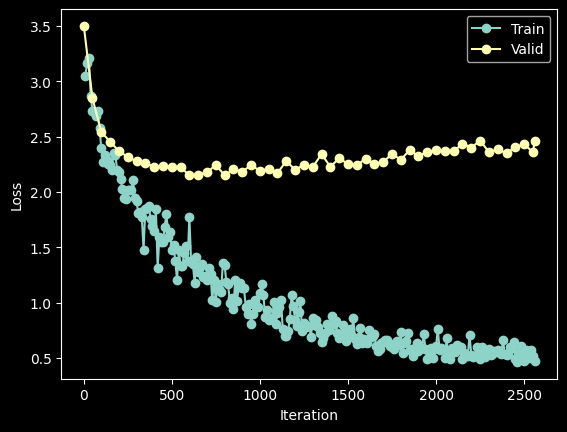

In [102]:
train_its, train_losses = zip(*metrics.train_losses)
val_its, val_losses = zip(*metrics.val_losses)
plt.plot(train_its, train_losses, '-o')
plt.plot(val_its, val_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(['Train', "Valid"])

### Fuse Adapters

Sometimes its convenient to fuse the adapters into the base model to create a single adapted model. MLX LM has a fuse script just for that.

The adapted weights are: $\tilde{W} = W + c \cdot \mathbf{b}^\top \mathbf{a}$. Note, this process can be destructive if the inputs are in low precision and they have very different magnitudes. Tuning the `scale` parameter, $c$, prior to fine-tuning can improve the model performance after fusion.

To see more options for fusing the model, including how to upload to HuggingFace [check the documentation](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#fuse).

In [103]:
# !mlx_lm.fuse --model {model_path}

Once the adapters are fused, we can rerun the evaluation using the fused model to make sure it worked. By default the fused model will be saved to `lora_fused_model`.

In [104]:
# model, tokenizer = load("lora_fused_model")
# num_correct = 0
# for prompt, answer in tqdm.tqdm(test_set[:num_test]):
#     response = generate(model, tokenizer, prompt, max_tokens=2)
#     num_correct += (response==answer)
# test_acc = num_correct / num_test
# print(f"Approximate test accuracy {test_acc:.3f}")

### Troubleshooting

#### Results

To figure out why your LoRA adapters are not working well it's critical to plot both the trianing loss and validation loss over the duration of fine-tuning. There are really only two cases to consider: underfitting or overfitting. And you can figure out which regime you are in based on the above plot.

**Underfitting**: The trianing loss is not low enough and the validation loss closely matches the training loss. You could also measure the accuracy on the training set itself for question-answering style tasks like HellaSwag. If you are in this regime you have a few options to improve the results:

- Use more adapters. Increase `lora_layers` or adapt more of the linear layers within a given block by setting `lora_parameters["keys"]`.
- Use a higher rank. A higher rank means more parameters per adapter.
- If you are using dropout, decrease the droupout rate or turn it off entirely.
- Sometimes, underfitting issues are really optimization issues. In these cases it can be helpful to tune the learning rate or learning rate schedule.
- If none of the above works, try a bigger model. For example, try Phi-3 medium instead of Phi-3 tiny.

**Overfitting**: The trianing loss keeps going down but the validation loss stops going down and even starts to go up. If you are in this regime you also have a few options:

- The best thing to do is to use more trianing data if you have it.
- Contrary to the underfitting regime decreasing the capacity of the model can help. For example, use fewer adapters, a lower LoRA rank, or a smaller model size.
- If you are not using dropout, use it.

If you find your adapters work well pre-fusion but stop working post-fusion, try tuning the `scale` parameter, $c$, prior to fine-tuning. Typically the adapters have a smaller magnitude than the weights, so using a larger scale helps.

#### Memory Use

Fine-tuning a large LM with LoRA requires a machine with a decent amount of memory. Here are some tips to reduce memory use should you need to do so. 

- Try quantization (QLoRA). You can use QLoRA by generating a quantized model with `mlx_lm.convert` and the `-q` flag or by using an already quantized model from HuggingFace.

- Try using a smaller batch size. You can set the `batch_size` parameter in the `TrainingArgs` or pass `--batch-size` if you are using the CLI. The default is 4 so setting this to 2 or 1 will reduce memory consumption. Note, this may slow things down a little..

- Reduce the number of layers to fine-tune with by setting `lora_layers` to a smaller value or passing `--lora-layers` if you are using the CLI. The default is `16`, so you can try `8` or `4`. This reduces the amount of memory needed for back propagation. It may also reduce the quality of the fine-tuned model and you may need to compensate with a larger `rank`.

- Longer examples require more memory. If it makes sense for your data, one thing you can do is break your examples into smaller sequences when making the `train`, `valid`, and `test` data sets.

- Gradient checkpointing lets you trade-off memory use (less) for computation (more) by recomputing instead of storing intermediate values needed by the backward pass. You can use gradient checkpointing by passing `grad_checkpoint=True` to the `TrainingArgs` or the `--grad-checkpoint` flag if using the CLI. Gradient checkpointing will be more helpful for larger batch sizes or sequence lengths with smaller or quantized models.

### Next Steps

- To learn more about MLX check-out the [GitHub repo](http://github.com/ml-explore/mlx) and [documentation](https://ml-explore.github.io/mlx/)
- For more on MLX LM check-out the [MLX LM documentation](https://github.com/ml-explore/mlx-examples/tree/main/llms#readme).
- Check out the other [MLX Examples](https://github.com/ml-explore/mlx-examples/tree/main). These are great as a learning resource or to use as a starting point for a new project.
- We also have an example of [LoRA fine-tuning in MLX Swift](https://github.com/ml-explore/mlx-swift-examples/tree/main/Applications/LoRATrainingExample).